# 1. Load and Explore the data

## 1.1 Import the libraries

In [1]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2 as ps
import numpy as np
from sklearn.pipeline import Pipeline
import feature_engine.imputation as mdi
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

## 1.2 Import the dataset

(Done by Nehaa)

In [2]:
conn = ps.connect(dbname="postgres",
                   user="postgres",
                   password="postgres",
                   host = "localhost",
                    port="5432")

In [3]:
# Fetch data from the database
sql_area = """SELECT * FROM public.area"""
sql_farm = """SELECT * FROM public.farm"""
sql_product = """SELECT * FROM public.product"""
sql_sale_order = """SELECT * FROM public.sale_order"""
sql_sale_order_item = """SELECT * FROM public.sale_order_item"""

In [4]:
# Convert to DataFrame
df_area = pd.read_sql(sql_area, conn)
df_farm = pd.read_sql(sql_farm, conn)
df_product = pd.read_sql(sql_product, conn)
df_sale_order = pd.read_sql(sql_sale_order, conn)
df_sale_order_item = pd.read_sql(sql_sale_order_item, conn)

C:\Users\nehaa\AppData\Local\Temp\ipykernel_20060\3184278191.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_area = pd.read_sql(sql_area, conn)
C:\Users\nehaa\AppData\Local\Temp\ipykernel_20060\3184278191.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_farm = pd.read_sql(sql_farm, conn)
C:\Users\nehaa\AppData\Local\Temp\ipykernel_20060\3184278191.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_product = pd.read_sql(sql_product, conn)
C:\Users\nehaa\AppData\Local\Temp\ipykernel_20060\3184278191.py:5: Use

## 1.3 Show and merge the data into 2 master dataframes

### 1.3.1 df_area

In [5]:
# df_area
df_area.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 46 non-null     object 
 1   name               46 non-null     object 
 2   level_0            46 non-null     object 
 3   level_1            46 non-null     object 
 4   level_2            46 non-null     object 
 5   level_3            46 non-null     object 
 6   level_3_latitude   46 non-null     float64
 7   level_3_longitude  46 non-null     float64
 8   level_4            46 non-null     object 
 9   level_4_latitude   46 non-null     float64
 10  level_4_longitude  46 non-null     float64
dtypes: float64(4), object(7)
memory usage: 4.1+ KB


In [6]:
# update the df_area columns for readability
df_area = df_area.rename(columns={'id': 'area_id', 'name': 'area_name', 'level_0': 'country', 'level_1': 'province', 'level_2': 'city', 
                                  'level_3': 'district', 'level_3_latitude': 'district_latitude', 'level_3_longitude': 'district_longitude', 
                                  'level_4': 'subdistrict', 'level_4_latitude': 'subdistrict_latitude', 
                                  'level_4_longitude': 'subdistrict_longitude'})

### 1.3.2 df_farm

In [7]:
# df_farm
df_farm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      100 non-null    object 
 1   owner_id                100 non-null    object 
 2   area_id                 100 non-null    object 
 3   latitude                2 non-null      float64
 4   longitude               2 non-null      float64
 5   area_hectare            100 non-null    float64
 6   planted_year            100 non-null    int64  
 7   planted_month           100 non-null    int64  
 8   palm_trees_per_hectare  48 non-null     float64
 9   soil_type               100 non-null    object 
 10  seed_type               28 non-null     object 
dtypes: float64(4), int64(2), object(5)
memory usage: 8.7+ KB


In [8]:
# update the df_farm columns for readability
df_farm = df_farm.rename(columns={'id': 'farm_id', 'latitude': 'farm_latitude', 'longitude': 'farm_longitude'})

### 1.3.3 Merge df_area & df_farm into df_product

In [9]:
# check df_area & df_farm for overlaps

# Extract farm_ids from both DataFrames
set1 = set(df_area['area_id'])
set2 = set(df_farm['area_id'])

# Find overlapping farm_ids
overlap = set1.intersection(set2)
print("Overlap count:", len(overlap))
print("Overlap farm_ids:", overlap)

Overlap count: 46
Overlap farm_ids: {'ID1209182011', 'ID1205202005', 'ID1205012003', 'ID1223052007', 'ID1222052002', 'ID3211012006', 'ID1471041002', 'ID1223052010', 'ID1303092002', 'ID1505012007', 'ID1407131002', 'ID1205202006', 'ID1901042008', 'ID1601322001', 'ID1207242015', 'ID1901082004', 'ID1505011003', 'ID1223052006', 'ID1102032026', 'ID1205052007', 'ID1223052018', 'ID1709042007', 'ID1205201001', 'ID1222052003', 'ID1509011001', 'ID1223032007', 'ID1508092011', 'ID1210092001', 'ID1674032004', 'ID1101142007', 'ID1504021002', 'ID1220082034', 'ID1223012005', 'ID1209212006', 'ID1401172001', 'ID1508092008', 'ID1508121001', 'ID3529062001', 'ID1101032013', 'ID1802102003', 'ID1205012002', 'ID1507091001', 'ID3173051001', 'ID1508092014', 'ID1102022015', 'ID1205012012'}


In [10]:
# merge df_area & df_farm
df = pd.merge(df_area, df_farm, on='area_id', how='inner')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   area_id                 100 non-null    object 
 1   area_name               100 non-null    object 
 2   country                 100 non-null    object 
 3   province                100 non-null    object 
 4   city                    100 non-null    object 
 5   district                100 non-null    object 
 6   district_latitude       100 non-null    float64
 7   district_longitude      100 non-null    float64
 8   subdistrict             100 non-null    object 
 9   subdistrict_latitude    100 non-null    float64
 10  subdistrict_longitude   100 non-null    float64
 11  farm_id                 100 non-null    object 
 12  owner_id                100 non-null    object 
 13  farm_latitude           2 non-null      float64
 14  farm_longitude          2 non-null      flo

In [11]:
# df_product
df_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   41 non-null     object 
 1   sku                  41 non-null     object 
 2   type                 41 non-null     object 
 3   unit_of_measurement  41 non-null     object 
 4   name                 41 non-null     object 
 5   price                41 non-null     float64
 6   description          41 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.4+ KB


In [12]:
# update the df_product columns for readability
df_product = df_product.rename(columns={'id': 'product_id', 'sku': 'product_sku', 'type': 'product_type', 'name': 'product_name', 
                                        'price': 'product_price', 'description': 'product_description'})

### 1.3.4 df_sale_order

In [13]:
# df_sale_order
df_sale_order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                100 non-null    object 
 1   user_id           100 non-null    object 
 2   total_item_price  100 non-null    float64
 3   created_at_utc0   100 non-null    int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 3.3+ KB


In [14]:
# update the df_sale_order columns for readability
df_sale_order = df_sale_order.rename(columns={'id': 'sale_order_id', 'created_at_utc0': 'time_of_sale'})

### 1.3.5 df_sale_order_item

In [15]:
# df_sale_order_item
df_sale_order_item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             116 non-null    object 
 1   sale_order_id  116 non-null    object 
 2   product_id     116 non-null    object 
 3   quantity       116 non-null    int64  
 4   price          116 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.7+ KB


In [16]:
# update the df_sale_order_item columns for readability
df_sale_order_item = df_sale_order_item.rename(columns={'id': 'farm_id'})

### 1.3.6 Merge df_sale_order_item & df_sale_order into df_sale_order_item

In [17]:
# check df_sale_order_item & df_sale_order for overlaps

# Extract farm_ids from both DataFrames
set1 = set(df_sale_order_item['sale_order_id'])
set2 = set(df_sale_order['sale_order_id'])

# Find overlapping farm_ids
overlap = set1.intersection(set2)
print("Overlap count:", len(overlap))
print("Overlap farm_ids:", overlap)

Overlap count: 100
Overlap farm_ids: {'578e32df-b8f3-4fce-b9c9-2d3e059dcf24', '6196b833-aa6f-4508-bfae-bcf61403b9b9', 'c2064f86-6d1e-40ee-9ffe-e29a6f147c88', '696fc0d9-1456-42a4-9b4b-97c987ac564d', '630dca51-39ff-4b64-a4ee-6d9007199e8b', 'fec82ea7-3f70-43eb-97db-e10d9f3073db', '86ec48cf-8e0f-4267-be17-fba2c7220d0c', '6090bbb6-c528-4223-af54-72394b4166bb', '0cfe6a21-74db-45a9-ae87-b39cc733173c', 'f5939407-c4f6-4445-b1c2-323614affeb4', 'adfeffc1-dbb4-4a9d-893a-2c9323c31b07', 'a73cc2d8-f73e-438c-9d5e-9f14b47fc7c4', '4346187f-5f63-4d5f-8d12-b494143bce30', '25c230cb-5762-4859-8525-db540f4f9bf3', 'd20a9066-aed8-4082-98e6-7abc62b7bf78', '5eba2371-a65e-4b2f-8d91-4df09de693c4', '2e93d18b-65de-41be-a43f-3f6e7ce7a5a3', 'b81ae23b-012b-46fb-ba63-12364918ec31', '20f151bd-8ad2-4fba-8e33-e900d8036701', 'e5819416-6b56-4337-9271-dc2c701ac7bd', 'c39f3603-76ef-479c-b866-eed205d15d17', 'd9b61f55-7569-46a3-8029-010beb05e099', '876120bd-3540-4588-b9f5-6beb3acc7e05', 'ae7fdd61-1d4d-44e6-950e-cf1bf4dbd832', '0

In [18]:
# merge df_sale_order_item & df_sale_order
df_sale = pd.merge(
    df_sale_order_item,
    df_sale_order,
    on='sale_order_id',
    how='inner'
)

df_sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   farm_id           116 non-null    object 
 1   sale_order_id     116 non-null    object 
 2   product_id        116 non-null    object 
 3   quantity          116 non-null    int64  
 4   price             116 non-null    float64
 5   user_id           116 non-null    object 
 6   total_item_price  116 non-null    float64
 7   time_of_sale      116 non-null    int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 7.4+ KB


In [19]:
# check df_sale & df_product for overlaps

# Extract farm_ids from both DataFrames
set1 = set(df_sale['product_id'])
set2 = set(df_product['product_id'])

# Find overlapping farm_ids
overlap = set1.intersection(set2)
print("Overlap count:", len(overlap))
print("Overlap farm_ids:", overlap)

Overlap count: 41
Overlap farm_ids: {'487f2886-5150-4269-94e2-63fbc7314971', 'beb17fe4-5d92-4738-adaa-2d62ffb83516', 'b67588d2-e8fe-4ee4-9931-e9d18241d04c', '2485b082-5258-44c1-b6aa-983387d540a7', 'd3999f4e-890a-473f-bb92-2fd2178da3fb', 'ff58b8c4-1058-4753-bfc0-c04d091c8485', 'd8232157-edeb-4ac8-ba5a-0cf53e3c8a06', 'e41e1522-bbe0-4e9b-b638-5470e82e13a5', '5110ed03-9e1e-44bd-913c-4f56de2dcf0b', '4698d965-a133-4701-838b-f60e38c66b39', 'c5e57af4-0df9-4e2b-87e4-9024b8e6cf53', '8152e395-0f7a-4dda-8df9-6655a726c4e1', '944f4171-813b-4423-ad89-3c73d67f9986', '6eccf249-a997-4091-8d64-29f1e9accd85', 'c2b3d62f-6c48-4051-beb1-3ec66d30c1da', '6c27fc9c-e7e9-4e9b-9017-292175250df1', '8df8c2e5-5ad8-490f-83b2-57fa0c961f84', '8acff85f-f70a-4308-801f-763b22bb25c7', '701928af-24e9-4a13-aaad-63ede44be9c8', '8fcfd7a8-5980-4e7e-b463-6d30823caac4', '9e7cc609-f4ef-4246-89e7-756861e623d8', '2b8fe2f0-5d07-459c-8781-22305a61980a', '89f26d03-4933-4924-ae31-5eef6981122f', '1af0394e-3aea-42b4-8698-b6832e35f8ce', '55

In [20]:
# merge df_sale & df_product
df_sale = pd.merge(
    df_sale,
    df_product,
    on='product_id',
    how='inner'
)

df_sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   farm_id              116 non-null    object 
 1   sale_order_id        116 non-null    object 
 2   product_id           116 non-null    object 
 3   quantity             116 non-null    int64  
 4   price                116 non-null    float64
 5   user_id              116 non-null    object 
 6   total_item_price     116 non-null    float64
 7   time_of_sale         116 non-null    int64  
 8   product_sku          116 non-null    object 
 9   product_type         116 non-null    object 
 10  unit_of_measurement  116 non-null    object 
 11  product_name         116 non-null    object 
 12  product_price        116 non-null    float64
 13  product_description  116 non-null    object 
dtypes: float64(3), int64(2), object(9)
memory usage: 12.8+ KB


### 1.3.7 Display the 2 master dataframes

In [21]:
# display df_farm
df_farm = df
df_farm.info()
df_farm.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   area_id                 100 non-null    object 
 1   area_name               100 non-null    object 
 2   country                 100 non-null    object 
 3   province                100 non-null    object 
 4   city                    100 non-null    object 
 5   district                100 non-null    object 
 6   district_latitude       100 non-null    float64
 7   district_longitude      100 non-null    float64
 8   subdistrict             100 non-null    object 
 9   subdistrict_latitude    100 non-null    float64
 10  subdistrict_longitude   100 non-null    float64
 11  farm_id                 100 non-null    object 
 12  owner_id                100 non-null    object 
 13  farm_latitude           2 non-null      float64
 14  farm_longitude          2 non-null      flo

,area_id,area_name,country,province,city,district,district_latitude,district_longitude,subdistrict,subdistrict_latitude,...,farm_id,owner_id,farm_latitude,farm_longitude,area_hectare,planted_year,planted_month,palm_trees_per_hectare,soil_type,seed_type
0,ID1101032013,"Ujung Pasir, Kluet Selatan, Aceh Selatan, Aceh",Indonesia,Aceh,Aceh Selatan,Kluet Selatan,3.05166,97.45977,Ujung Pasir,3.079105,...,f9896038-ddeb-4a63-bfb5-bfc35f9accd0,5adfd8d9-7a11-455b-90e8-62d22eb4fe91,NaN,NaN,1.0,2025,4,4.0,Mineral,SEM
1,ID1101032013,"Ujung Pasir, Kluet Selatan, Aceh Selatan, Aceh",Indonesia,Aceh,Aceh Selatan,Kluet Selatan,3.05166,97.45977,Ujung Pasir,3.079105,...,b61a9182-e109-42e3-8556-c22f4c88dab0,8c0e41e7-7a5f-4ff1-b42e-55aa219441d3,NaN,NaN,1.0,2025,4,NaN,Mineral,Dami Mas
2,ID1101142007,"Pucuk Lembang, Kluet Timur, Aceh Selatan, Aceh",Indonesia,Aceh,Aceh Selatan,Kluet Timur,3.17104,97.45977,Pucuk Lembang,3.161074,...,d231eb01-bc2c-46a6-a69a-adfb3c22988e,19d2c440-c133-49a9-9f42-de81b4938449,NaN,NaN,3000.0,2018,4,120.0,Mineral,Socfindo
3,ID1102022015,"Suka Maju, Lawe Sigala-Gala, Aceh Tenggara, Aceh",Indonesia,Aceh,Aceh Tenggara,Lawe Sigala-Gala,3.35698,97.92660,Suka Maju,3.356778,...,e7a8893a-e765-437a-a5d9-838274ee2419,dfa538d5-12f4-4a1f-b4e5-fadf961f9c36,NaN,NaN,1.0,2009,5,NaN,Mineral,None
4,ID1102022015,"Suka Maju, Lawe Sigala-Gala, Aceh Tenggara, Aceh",Indonesia,Aceh,Aceh Tenggara,Lawe Sigala-Gala,3.35698,97.92660,Suka Maju,3.356778,...,6807037a-f75c-4f34-9814-5b19e59c0d4a,6ff1149e-cd24-40f7-8170-37cfe02aafb0,NaN,NaN,2.0,2009,5,NaN,Mineral,None


In [22]:
# display df_sale
df_sale.info()
df_sale.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   farm_id              116 non-null    object 
 1   sale_order_id        116 non-null    object 
 2   product_id           116 non-null    object 
 3   quantity             116 non-null    int64  
 4   price                116 non-null    float64
 5   user_id              116 non-null    object 
 6   total_item_price     116 non-null    float64
 7   time_of_sale         116 non-null    int64  
 8   product_sku          116 non-null    object 
 9   product_type         116 non-null    object 
 10  unit_of_measurement  116 non-null    object 
 11  product_name         116 non-null    object 
 12  product_price        116 non-null    float64
 13  product_description  116 non-null    object 
dtypes: float64(3), int64(2), object(9)
memory usage: 12.8+ KB


,farm_id,sale_order_id,product_id,quantity,price,user_id,total_item_price,time_of_sale,product_sku,product_type,unit_of_measurement,product_name,product_price,product_description
0,d4dc9c06-177e-494c-ba72-7e2954ce8ced,3ddca641-cb59-4a27-8698-cb16ff2932f2,80957603-6cec-4f63-8dcd-aba6ded5cbdd,200,326000.0,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,101110501601,GOODS,kg,MOP/KCL Canada Cap Mahkota 50kg,712500.0,Pupuk MOP/KCL untuk meningkatkan Kualitas dan ...
1,7eefa7db-26bf-4a8b-b207-f44a52ed0aba,3ddca641-cb59-4a27-8698-cb16ff2932f2,b53ce31c-3789-42d7-96a0-5fe058cac7a5,200,125000.0,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,101110502101,GOODS,kg,RP Mahkota 50kg - Egypt,352688.0,Rock Phosphate (RP) adalah salah satu sumber f...
2,e9b32dc3-4e0f-4a69-bb3d-c7f11277f97f,787bc8b7-e679-4772-be5d-af4afac9adf5,5952d124-7dc6-4a6a-baa2-e2e502ecd6fe,1,109000.0,1e75f22f-b609-4ebc-9536-4a26aef73302,109000.0,1744182202966,TUP/PLN/100,DIGITAL,,Token PLN 100.000,109000.0,Topup PLN 100.000 Topup PLN 100.000
3,86a41dec-9936-4c8f-9150-e8b367a4959f,4d47dd32-1618-4376-a846-66bcf065e173,0bd2430a-6613-442a-9d5a-11d64cb095ae,1,65000.0,344963f8-9a3a-4de3-b3a9-c8716fa37c0e,65000.0,1742438712361,MERCH-SAWITPRO-SHIRT-02,GOODS,kg,Kaos SIBRONDOL SawitPRO size XL,100000.0,<p>Kaos tidak berkerah warna Putih bertuliskan...
4,61cf5f3f-2a24-4080-bc4f-50af3506479d,e5819416-6b56-4337-9271-dc2c701ac7bd,80957603-6cec-4f63-8dcd-aba6ded5cbdd,2,688750.0,49ad56f8-8d32-408f-9f88-36cad5310680,1377500.0,1744874598061,101110501601,GOODS,kg,MOP/KCL Canada Cap Mahkota 50kg,712500.0,Pupuk MOP/KCL untuk meningkatkan Kualitas dan ...


## 1.4 Exploratory Data Analysis

### 1.4.1 Univariate

### 1.4.2 Bivariate

### 1.4.3 Multivariate

# 2. Clean the Data

## 2.1 df_farm

### 2.1.1 Dropping unnecessary columns

In [23]:
df_farm = df_farm.drop(columns=['farm_latitude', 'farm_longitude'])

### 2.1.2 Handle missing values

In [24]:
# showing which columns have missing data
df_farm.isnull().mean().sort_values()

area_id                   0.00
planted_month             0.00
planted_year              0.00
area_hectare              0.00
owner_id                  0.00
farm_id                   0.00
subdistrict_longitude     0.00
soil_type                 0.00
subdistrict_latitude      0.00
district_longitude        0.00
district_latitude         0.00
district                  0.00
city                      0.00
province                  0.00
country                   0.00
area_name                 0.00
subdistrict               0.00
palm_trees_per_hectare    0.52
seed_type                 0.72
dtype: float64

In [25]:
# make a list with numerical variables (mean) and categorical variables (frequent). 

features_num_mean = ['palm_trees_per_hectare'] # list with numerical values

features_cat_frequent = ['seed_type'] # list with categorical values

In [26]:
# instantiate each imputer within a pipeline
pipe = Pipeline(steps=[ # defining pipeline
    ('imp_num_mean', mdi.MeanMedianImputer(imputation_method = 'mean', variables=features_num_mean)), # imputing numerical
    ('imp_cat_frequent', mdi.CategoricalImputer(variables = features_cat_frequent, imputation_method='frequent')) # imputing categorical
])

# fit the preprocessor
pipe.fit(df_farm)

Pipeline(steps=[('imp_num_mean',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['palm_trees_per_hectare'])),
                ('imp_cat_frequent',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['seed_type']))])

In [27]:
# impute the data
df_farm = pipe.transform(df_farm)

df_farm.isnull().sum() # show the final number of null values after imputation

area_id                   0
area_name                 0
country                   0
province                  0
city                      0
district                  0
district_latitude         0
district_longitude        0
subdistrict               0
subdistrict_latitude      0
subdistrict_longitude     0
farm_id                   0
owner_id                  0
area_hectare              0
planted_year              0
planted_month             0
palm_trees_per_hectare    0
soil_type                 0
seed_type                 0
dtype: int64

### 2.1.3 Handle outliers

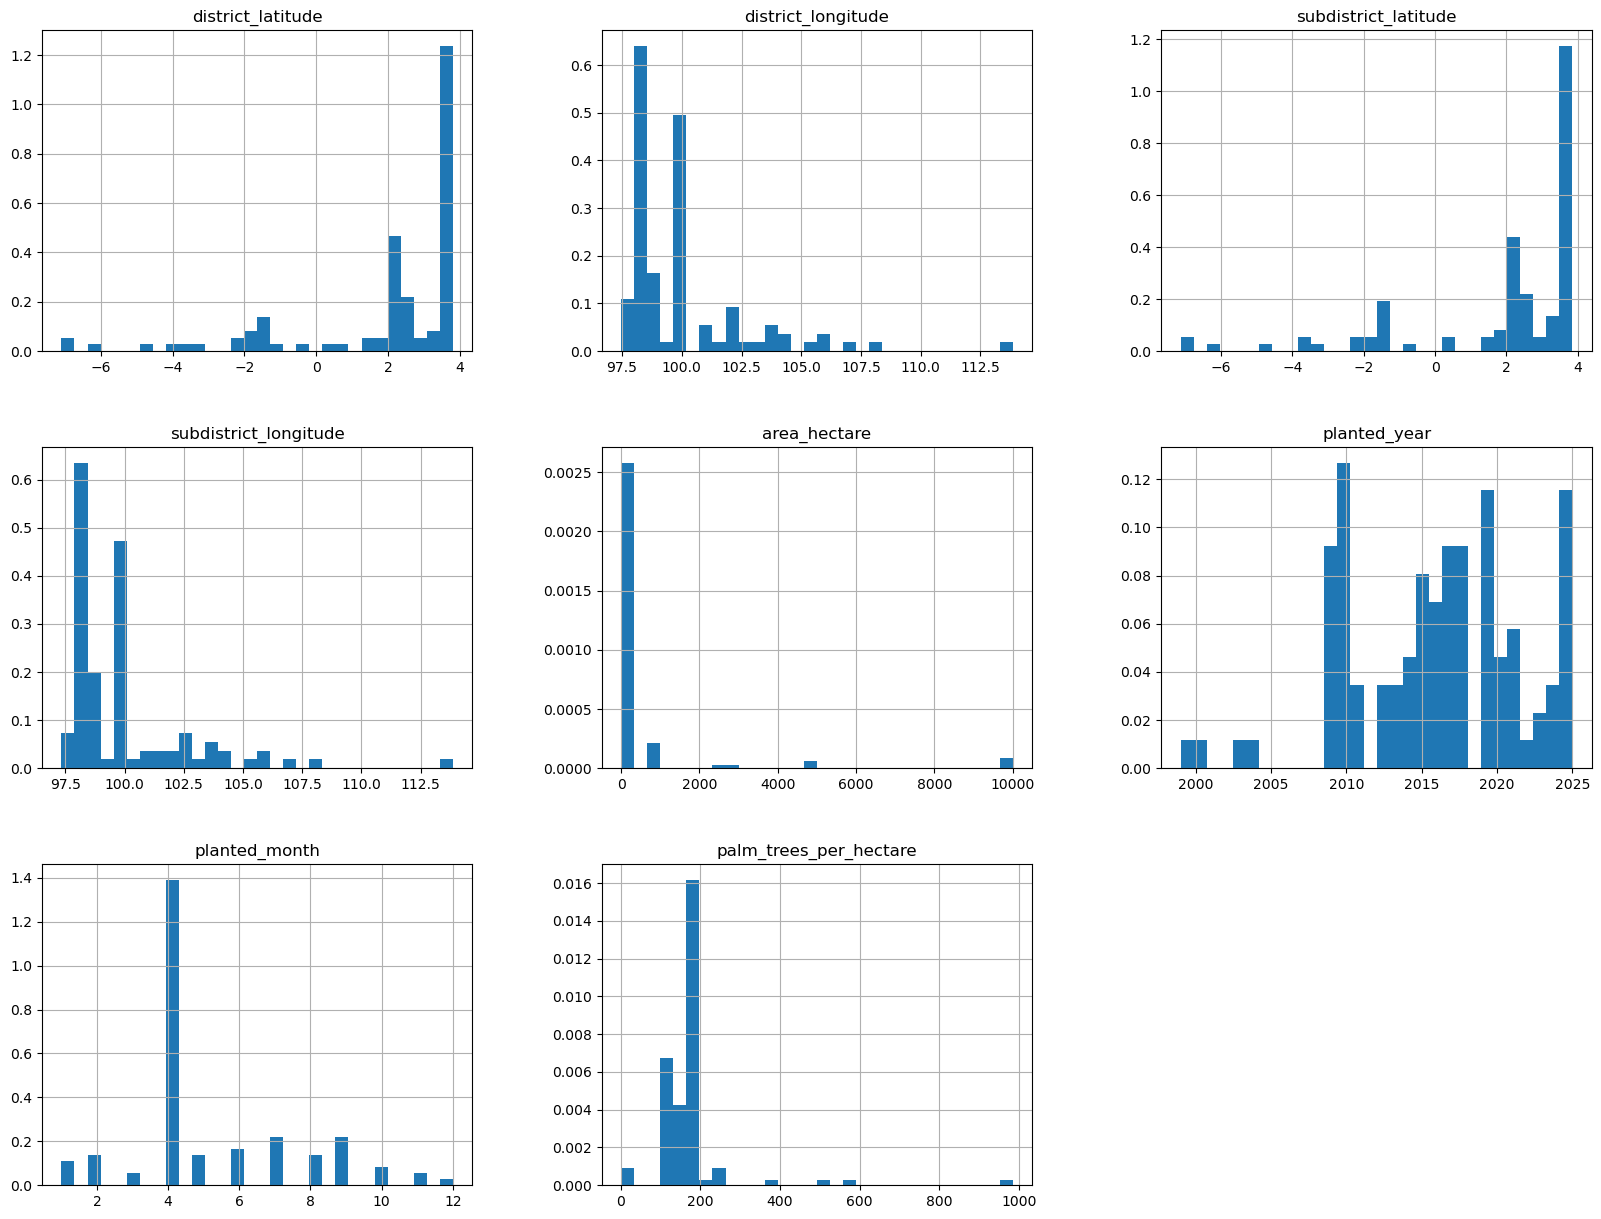

In [28]:
# showing the variable distribution in the df_farm in histograms
df_farm.hist(bins=30, figsize=(20, 15), density=True)
plt.show() # show the histogram

In [29]:
farm_num_cols = ['area_hectare', 'palm_trees_per_hectare'] # columns to work with for the outliers

print("Initial number of outliers:")

# Function to identify outliers using IQR method
def find_outliers_IQR(data): # define function
    outliers_indices = {} # adding a list so that it can be updated later on in the loop
    for col in data.select_dtypes(include=[np.number]).columns: # loop to find outliers in each column in num_cols
        Q1 = data[col].quantile(0.25) # finding the Q1
        Q3 = data[col].quantile(0.75) # finding the Q3
        IQR = Q3 - Q1 # finding the interquartile range
        lower_bound = Q1 - 1.5 * IQR # finding the lower boundary
        upper_bound = Q3 + 1.5 * IQR # finding the upper boundary
        outliers_indices[col] = data[(data[col] < lower_bound) | (data[col] > upper_bound)].index # finding the number of outliers
    return outliers_indices # return the final list

outliers_indices = find_outliers_IQR(df_farm[farm_num_cols]) # finding the number of values in the columns that are outliers

for col, indices in outliers_indices.items(): # print out the number of outliers for each column
    print(f'Outliers in {col}: {len(indices)}')

Initial number of outliers:
Outliers in area_hectare: 22
Outliers in palm_trees_per_hectare: 10


In [30]:
# Handle outliers (cap them at lower/upper bounds)
for col in farm_num_cols: # capping the outliers for all the columns specified earlier
    Q1 = df_farm[col].quantile(0.25) # finding the Q1
    Q3 = df_farm[col].quantile(0.75) # finding the Q3
    IQR = Q3 - Q1 # finding the interquartile range
    lower_bound = Q1 - 1.5 * IQR # finding the lower boundary
    upper_bound = Q3 + 1.5 * IQR # finding the upper boundary
    df_farm[col] = np.where(df_farm[col] < lower_bound, lower_bound, df_farm[col]) # dealing with the values that are less than Q1
    df_farm[col] = np.where(df_farm[col] > upper_bound, upper_bound, df_farm[col]) # dealing with the values that are more than Q3

In [31]:
print("\nFinal number of outliers after capping:")    

# Check that outliers have been handeled
for col in farm_num_cols:
    Q1 = df_farm[col].quantile(0.25) # finding the Q1
    Q3 = df_farm[col].quantile(0.75) # finding the Q3
    IQR = Q3 - Q1 # finding the interquartile range
    lower_bound = Q1 - 1.5 * IQR # finding the lower boundary
    upper_bound = Q3 + 1.5 * IQR # finding the upper boundary
    outliers = df_farm[(df_farm[col] < lower_bound) | (df_farm[col] > upper_bound)] # finding the number of outliers
    print(f'Outliers in {col}: {len(outliers)}') # printing the number of outliers left after capping


Final number of outliers after capping:
Outliers in area_hectare: 0
Outliers in palm_trees_per_hectare: 0


## 2.2 df_sale

### 2.2.1 Handle missing values

In [32]:
# showing which columns have missing data
df_sale.isnull().mean().sort_values()

farm_id                0.0
sale_order_id          0.0
product_id             0.0
quantity               0.0
price                  0.0
user_id                0.0
total_item_price       0.0
time_of_sale           0.0
product_sku            0.0
product_type           0.0
unit_of_measurement    0.0
product_name           0.0
product_price          0.0
product_description    0.0
dtype: float64

### 2.2.2 Handle outliers

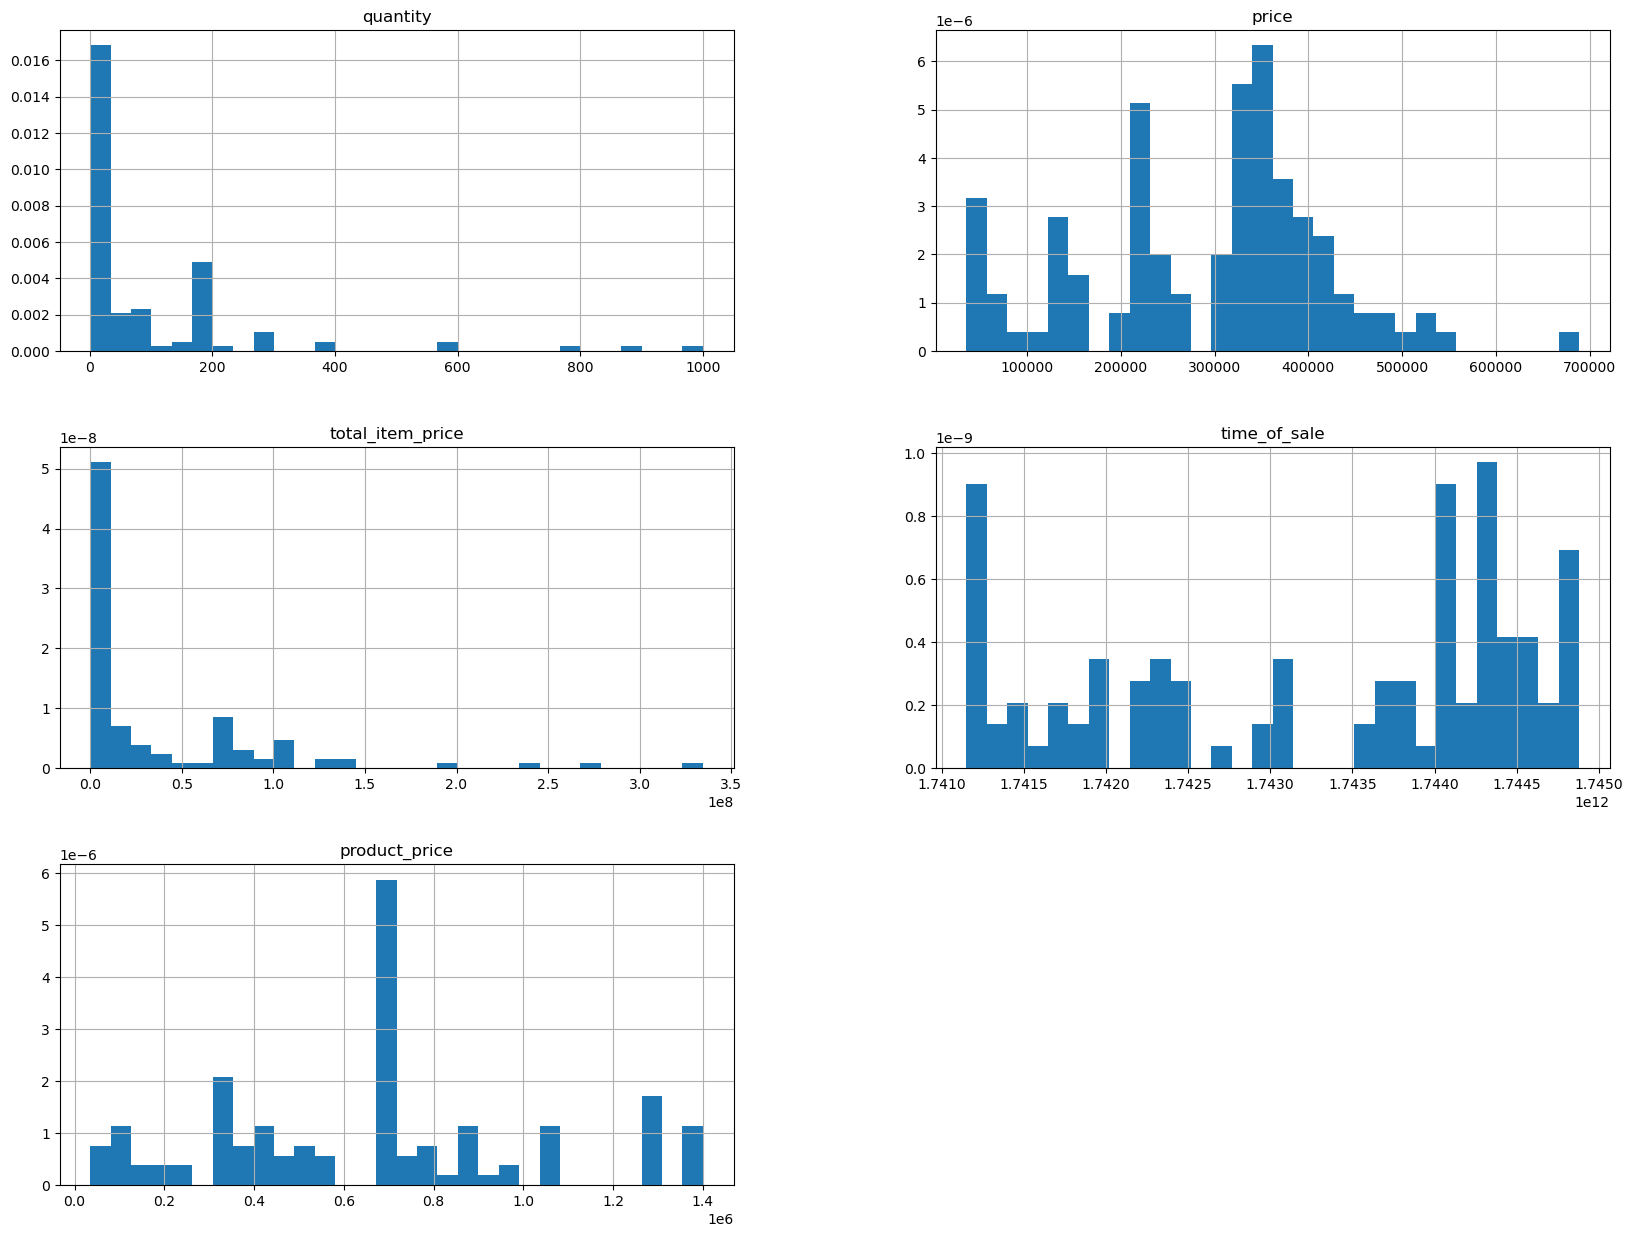

In [33]:
# showing the variable distribution in the df_farm in histograms
df_sale.hist(bins=30, figsize=(20, 15), density=True)
plt.show() # show the histogram

In [34]:
sale_num_cols = ['quantity', 'price', 'total_item_price'] # columns to work with for the outliers

print("Initial number of outliers:")

# Function to identify outliers using IQR method
def find_outliers_IQR(data): # define function
    outliers_indices = {} # adding a list so that it can be updated later on in the loop
    for col in data.select_dtypes(include=[np.number]).columns: # loop to find outliers in each column in num_cols
        Q1 = data[col].quantile(0.25) # finding the Q1
        Q3 = data[col].quantile(0.75) # finding the Q3
        IQR = Q3 - Q1 # finding the interquartile range
        lower_bound = Q1 - 1.5 * IQR # finding the lower boundary
        upper_bound = Q3 + 1.5 * IQR # finding the upper boundary
        outliers_indices[col] = data[(data[col] < lower_bound) | (data[col] > upper_bound)].index # finding the number of outliers
    return outliers_indices # return the final list

outliers_indices = find_outliers_IQR(df_sale[sale_num_cols]) # finding the number of values in the columns that are outliers

for col, indices in outliers_indices.items(): # print out the number of outliers for each column
    print(f'Outliers in {col}: {len(indices)}')

Initial number of outliers:
Outliers in quantity: 5
Outliers in price: 1
Outliers in total_item_price: 4


In [35]:
# Handle outliers (cap them at lower/upper bounds)
for col in sale_num_cols: # capping the outliers for all the columns specified earlier
    Q1 = df_sale[col].quantile(0.25) # finding the Q1
    Q3 = df_sale[col].quantile(0.75) # finding the Q3
    IQR = Q3 - Q1 # finding the interquartile range
    lower_bound = Q1 - 1.5 * IQR # finding the lower boundary
    upper_bound = Q3 + 1.5 * IQR # finding the upper boundary
    df_sale[col] = np.where(df_sale[col] < lower_bound, lower_bound, df_sale[col]) # dealing with the values that are less than Q1
    df_sale[col] = np.where(df_sale[col] > upper_bound, upper_bound, df_sale[col]) # dealing with the values that are more than Q3

In [36]:
print("\nFinal number of outliers after capping:")    

# Check that outliers have been handled
for col in sale_num_cols:
    Q1 = df_sale[col].quantile(0.25) # finding the Q1
    Q3 = df_sale[col].quantile(0.75) # finding the Q3
    IQR = Q3 - Q1 # finding the interquartile range
    lower_bound = Q1 - 1.5 * IQR # finding the lower boundary
    upper_bound = Q3 + 1.5 * IQR # finding the upper boundary
    outliers = df_farm[(df_sale[col] < lower_bound) | (df_sale[col] > upper_bound)] # finding the number of outliers
    print(f'Outliers in {col}: {len(outliers)}') # printing the number of outliers left after capping


Final number of outliers after capping:
Outliers in quantity: 0
Outliers in price: 0
Outliers in total_item_price: 0


C:\Users\nehaa\AppData\Local\Temp\ipykernel_20060\3788684400.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers = df_farm[(df_sale[col] < lower_bound) | (df_sale[col] > upper_bound)] # finding the number of outliers
C:\Users\nehaa\AppData\Local\Temp\ipykernel_20060\3788684400.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers = df_farm[(df_sale[col] < lower_bound) | (df_sale[col] > upper_bound)] # finding the number of outliers
C:\Users\nehaa\AppData\Local\Temp\ipykernel_20060\3788684400.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers = df_farm[(df_sale[col] < lower_bound) | (df_sale[col] > upper_bound)] # finding the number of outliers


### 2.2.3 Translate the product description

(Done by Nehaa)

In [37]:
# !pip install beautifulsoup4 googletrans==4.0.0-rc1

In [38]:
from bs4 import BeautifulSoup
from googletrans import Translator
import re
import pandas as pd

# Sample setup: assuming df_sale is already loaded
# df_sale = pd.read_csv('your_file.csv')

translator = Translator()

def clean_html(text):
    """Remove HTML tags and convert to plain text."""
    return BeautifulSoup(text, "html.parser").get_text(separator=" ") if pd.notnull(text) else ""

def normalize_whitespace(text):
    """Remove extra whitespace and newlines."""
    return re.sub(r'\s+', ' ', text).strip()

def translate_to_english(text):
    """Translate Indonesian text to English."""
    try:
        translated = translator.translate(text, src='id', dest='en')
        return translated.text
    except Exception as e:
        return text  # Fallback: return original if translation fails

def clean_and_translate(text):
    """Combined function to clean and translate."""
    no_html = clean_html(text)
    normalized = normalize_whitespace(no_html)
    translated = translate_to_english(normalized)
    return translated

# Apply to the 'product_description' column
df_sale['product_description_en'] = df_sale['product_description'].apply(clean_and_translate)

# Preview result
print(df_sale[['product_description', 'product_description_en']].head())

# Apply to the 'product_description' column
df_sale['product_name_en'] = df_sale['product_name'].apply(clean_and_translate)

# Preview result
print(df_sale[['product_name', 'product_name_en']].head())



                                 product_description  \
0  Pupuk MOP/KCL untuk meningkatkan Kualitas dan ...   
1  Rock Phosphate (RP) adalah salah satu sumber f...   
2                Topup PLN 100.000 Topup PLN 100.000   
3  <p>Kaos tidak berkerah warna Putih bertuliskan...   
4  Pupuk MOP/KCL untuk meningkatkan Kualitas dan ...   

                              product_description_en  
0  MOP/KCL fertilizer to improve the quality and ...  
1  Rock Phosphate (RP) is one of the best sources...  
2                Topup PLN 100,000 Topup PLN 100,000  
3  The white collared shirt that reads "Sibrondol...  
4  MOP/KCL fertilizer to improve the quality and ...  


C:\Users\nehaa\AppData\Local\Temp\ipykernel_20060\1748948745.py:13: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, "html.parser").get_text(separator=" ") if pd.notnull(text) else ""


                      product_name                      product_name_en
0  MOP/KCL Canada Cap Mahkota 50kg      MOP/KCL Canada Cap Mahkota 50kg
1          RP Mahkota 50kg - Egypt               Rp. 50kg crown - Egypt
2                Token PLN 100.000                    Token PLN 100,000
3  Kaos SIBRONDOL SawitPRO size XL  T -shirt Sibrondol Sawitpro Size XL
4  MOP/KCL Canada Cap Mahkota 50kg      MOP/KCL Canada Cap Mahkota 50kg


In [39]:
# df_sale = df_sale.drop("product_description")
# df_sale = df_sale.drop("product_name")


In [40]:
df_sale.head()

,farm_id,sale_order_id,product_id,quantity,price,user_id,total_item_price,time_of_sale,product_sku,product_type,unit_of_measurement,product_name,product_price,product_description,product_description_en,product_name_en
0,d4dc9c06-177e-494c-ba72-7e2954ce8ced,3ddca641-cb59-4a27-8698-cb16ff2932f2,80957603-6cec-4f63-8dcd-aba6ded5cbdd,200.0,326000.000,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,101110501601,GOODS,kg,MOP/KCL Canada Cap Mahkota 50kg,712500.0,Pupuk MOP/KCL untuk meningkatkan Kualitas dan ...,MOP/KCL fertilizer to improve the quality and ...,MOP/KCL Canada Cap Mahkota 50kg
1,7eefa7db-26bf-4a8b-b207-f44a52ed0aba,3ddca641-cb59-4a27-8698-cb16ff2932f2,b53ce31c-3789-42d7-96a0-5fe058cac7a5,200.0,125000.000,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,101110502101,GOODS,kg,RP Mahkota 50kg - Egypt,352688.0,Rock Phosphate (RP) adalah salah satu sumber f...,Rock Phosphate (RP) is one of the best sources...,Rp. 50kg crown - Egypt
2,e9b32dc3-4e0f-4a69-bb3d-c7f11277f97f,787bc8b7-e679-4772-be5d-af4afac9adf5,5952d124-7dc6-4a6a-baa2-e2e502ecd6fe,1.0,109000.000,1e75f22f-b609-4ebc-9536-4a26aef73302,109000.0,1744182202966,TUP/PLN/100,DIGITAL,,Token PLN 100.000,109000.0,Topup PLN 100.000 Topup PLN 100.000,"Topup PLN 100,000 Topup PLN 100,000","Token PLN 100,000"
3,86a41dec-9936-4c8f-9150-e8b367a4959f,4d47dd32-1618-4376-a846-66bcf065e173,0bd2430a-6613-442a-9d5a-11d64cb095ae,1.0,65000.000,344963f8-9a3a-4de3-b3a9-c8716fa37c0e,65000.0,1742438712361,MERCH-SAWITPRO-SHIRT-02,GOODS,kg,Kaos SIBRONDOL SawitPRO size XL,100000.0,<p>Kaos tidak berkerah warna Putih bertuliskan...,"The white collared shirt that reads ""Sibrondol...",T -shirt Sibrondol Sawitpro Size XL
4,61cf5f3f-2a24-4080-bc4f-50af3506479d,e5819416-6b56-4337-9271-dc2c701ac7bd,80957603-6cec-4f63-8dcd-aba6ded5cbdd,2.0,588484.375,49ad56f8-8d32-408f-9f88-36cad5310680,1377500.0,1744874598061,101110501601,GOODS,kg,MOP/KCL Canada Cap Mahkota 50kg,712500.0,Pupuk MOP/KCL untuk meningkatkan Kualitas dan ...,MOP/KCL fertilizer to improve the quality and ...,MOP/KCL Canada Cap Mahkota 50kg


### 2.2.4 Feature Extraction from Product Descriptions

(Done by Nehaa)

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

Item to item based recommendation system based on product description

In [42]:
# Converting the text in product description into numerical data for analysis
vectorizer = TfidfVectorizer(stop_words='english')
X1 = vectorizer.fit_transform(df_sale["product_description_en"])
X1

<116x691 sparse matrix of type '<class 'numpy.float64'>'
	with 7212 stored elements in Compressed Sparse Row format>

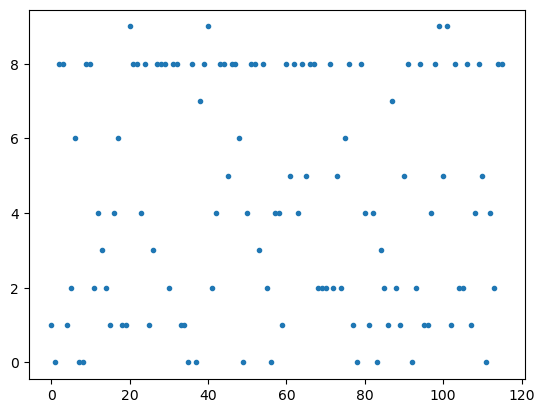

In [43]:
# Fitting K-Means to the dataset

X=X1

kmeans = KMeans(n_clusters = 10, init = 'k-means++')
y_kmeans = kmeans.fit_predict(X)
plt.plot(y_kmeans, ".")
plt.show()

In [44]:
def print_cluster(i):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

In [45]:
# # Optimal clusters is 

true_k = 10

model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X1)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(true_k):
    print_cluster(i)


Top terms per cluster:
Cluster 0:
 boron
 small
 essential
 plants
 seeds
 takes
 borat
 borate
 usually
 certain
Cluster 1:
 potassium
 kcl
 fertilizer
 plants
 60
 mop
 k2o
 require
 use
 quality
Cluster 2:
 50kg
 nitrea
 46
 urea
 granules
 drought
 effectiveness
 effectively
 effective
 economical
Cluster 3:
 sp
 organic
 sawitpro
 fertilizer
 nitrogen
 microorganisms
 decomposition
 janjang
 growth
 potassium
Cluster 4:
 magnesium
 27
 13
 fertilizer
 oxide
 boron
 growth
 plant
 sulfate
 phosphorus
Cluster 5:
 46
 urea
 nitrogen
 nitrea
 fertilizer
 sprinkled
 forage
 subsidized
 functions
 non
Cluster 6:
 powder
 processed
 phosphate
 stems
 rp
 plants
 phosphorus
 roots
 fertilizer
 improve
Cluster 7:
 weeds
 solution
 leaf
 herbicide
 sl
 wide
 tbm
 490
 narrow
 systemic
Cluster 8:
 100
 000
 pln
 topup
 dolomite
 200
 soil
 tsp
 super
 sawitpro
Cluster 9:
 sulfur
 zinc
 15
 number
 nitrogen
 plant
 za
 increase
 growth
 fertilizer


In [46]:
# Predicting clusters based on key search words
def show_recommendations(product):
    #print("Cluster ID:")
    Y = vectorizer.transform([product])
    prediction = model.predict(Y)
    #print(prediction)
    print_cluster(prediction[0])

In [47]:
# keyword: effective
show_recommendations("effective")

Cluster 8:
 100
 000
 pln
 topup
 dolomite
 200
 soil
 tsp
 super
 sawitpro


In case a word appears in multiple clusters, the algorithm chooses the cluster with the highest frequency of occurance of the word.

Output

- 
Recommendation of product based on the current product selected by user.- 
To recommend related product based on, Frequently bought together.

# 3. Build a User-Product Interaction Matrix (Recommendation Model)

## 3.1 Model 1 (By Arienne)

### 3.1.1 Building Model 1

In [48]:
# making the user-product interaction matrix
user_product_matrix = df_sale.pivot_table(
    index='user_id',
    columns='product_id',
    values='quantity',   # or 'total_item_price' if you prefer
    aggfunc='sum',
    fill_value=0
)

In [49]:
# Transpose the matrix to get product-user
product_user_matrix = user_product_matrix.T

# Compute item-item similarity
item_similarity = cosine_similarity(product_user_matrix)

# Turn into DataFrame
item_similarity_df = pd.DataFrame(item_similarity,
                                  index=product_user_matrix.index,
                                  columns=product_user_matrix.index)

#### 3.1.1.1 Based on products

In [50]:
def recommend_similar_products1(product_name, top_n=10):
    if product_name not in item_similarity_df:
        return f"{product_name} not found in product list."
    similar_scores = item_similarity_df[product_name].sort_values(ascending=False)
    return similar_scores.iloc[1:top_n+1]  # Skip the first one (it's the product itself)

# Example usage (key in product_id)
recommend_similar_products1('80957603-6cec-4f63-8dcd-aba6ded5cbdd')

# What it does:
# Takes a product_id and finds the top 5 most similar products based on cosine similarity scores.
# It skips the first one (because a product is always 100% similar to itself).
# Example use case: “If a user likes Product A, what else might they like?”
# If the product has no users in common with others → similarity = 0.

product_id
ece9fda2-1006-4cf9-a283-74e10b330512    0.821204
1033503b-8faa-4d5c-97c2-50bb19fbb897    0.285172
4cac8d01-b78e-4017-9113-c627ac1866a5    0.196691
e8898291-543b-439c-907f-bd80075f02a0    0.171112
b53ce31c-3789-42d7-96a0-5fe058cac7a5    0.142332
a48adaed-ab06-4245-8da6-5d560636a1d9    0.133463
369cfbc5-f536-41f5-8a80-267d55dec802    0.002139
1af0394e-3aea-42b4-8698-b6832e35f8ce    0.001913
ecef7b49-b297-4c53-bf53-628861221da7    0.000512
c2b3d62f-6c48-4051-beb1-3ec66d30c1da    0.000117
Name: 80957603-6cec-4f63-8dcd-aba6ded5cbdd, dtype: float64

#### 3.1.1.2 Based on user

In [51]:
def recommend_for_user1(user_id, top_n=10):
    if user_id not in user_product_matrix.index:
        return f"{user_id} not found."

    user_purchases = user_product_matrix.loc[user_id]
    purchased = user_purchases[user_purchases > 0].index.tolist()

    scores = pd.Series(dtype='float64')

    for product in purchased:
        similar_products = item_similarity_df[product].drop(purchased)
        scores = scores.add(similar_products, fill_value=0)

    return scores.sort_values(ascending=False).head(top_n)

# key in user_id
recommend_for_user1('13f5223e-f04a-4fa8-9ef2-cf36060f0d6d')

# What it does:
# Takes a user ID, finds the products they’ve already bought, and then:
# Looks up products similar to those they’ve bought.
# Combines all the scores of those similar products (ignores products already purchased).
# Recommends the top 5 highest scoring ones.

product_id
ece9fda2-1006-4cf9-a283-74e10b330512    0.821204
1033503b-8faa-4d5c-97c2-50bb19fbb897    0.285372
4cac8d01-b78e-4017-9113-c627ac1866a5    0.196691
e8898291-543b-439c-907f-bd80075f02a0    0.171112
a48adaed-ab06-4245-8da6-5d560636a1d9    0.136040
369cfbc5-f536-41f5-8a80-267d55dec802    0.012119
1af0394e-3aea-42b4-8698-b6832e35f8ce    0.010840
c2b3d62f-6c48-4051-beb1-3ec66d30c1da    0.000662
ecef7b49-b297-4c53-bf53-628861221da7    0.000512
6c27fc9c-e7e9-4e9b-9017-292175250df1    0.000032
dtype: float64

### 3.1.2 Evaluation of Model 1

#### 3.2.1 Based on products

In [52]:
# calculate precision
def precision_at_k(user_id, k=10):
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    recommended_products = []

    for product in actual_purchases:
        similar = recommend_similar_products1(product, top_n=k)
        if isinstance(similar, pd.Series):
            recommended_products.extend(similar.index.tolist())

    recommended_products = list(set(recommended_products))  # remove duplicates
    precision = len(set(recommended_products) & set(actual_purchases)) / k if k > 0 else 0
    return precision

In [53]:
# calculate recall
def recall_at_k(user_id, k=10):
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    recommended_products = []

    for product in actual_purchases:
        similar = recommend_similar_products1(product, top_n=k)
        if isinstance(similar, pd.Series):
            recommended_products.extend(similar.index.tolist())

    recommended_products = list(set(recommended_products))
    if len(actual_purchases) == 0:
        return 0
    recall = len(set(recommended_products) & set(actual_purchases)) / len(actual_purchases)
    return recall

In [54]:
# calculate f1
def f1_score(user_id, k=10):
    precision = precision_at_k(user_id, k)
    recall = recall_at_k(user_id, k)
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

In [55]:
# Evaluate for all users
user_ids = user_product_matrix.index.tolist()
precision_scores = [precision_at_k(user_id) for user_id in user_ids]
recall_scores = [recall_at_k(user_id) for user_id in user_ids]
f1_scores = [f1_score(user_id) for user_id in user_ids]

# Averages
avg_precision = sum(precision_scores) / len(precision_scores)
avg_recall = sum(recall_scores) / len(recall_scores)
avg_f1 = sum(f1_scores) / len(f1_scores)

print(f"Average Precision: {avg_precision}")
print(f"Average Recall: {avg_recall}")
print(f"Average F1 Score: {avg_f1}")

Average Precision: 0.0547945205479452
Average Recall: 0.18493150684931506
Average F1 Score: 0.08165605546749785


#### 3.2.2 Based on user

In [56]:
# calculate precision
def precision_at_k(user_id, k=10):
    recommended_products = recommend_for_user1(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    # Calculate Precision at K
    precision = len(set(recommended_products) & set(actual_purchases)) / k
    return precision

# What this does
# This checks how many of the top k recommended products the user actually purchased.
# gives the overlap between recommended and actual products.
# We divide by k (total recommended) to get the precision (how accurate our suggestions were).

In [57]:
# calculate recall
def recall_at_k(user_id, k=10):
    recommended_products = recommend_for_user1(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    # Calculate Recall at K
    recall = len(set(recommended_products) & set(actual_purchases)) / len(actual_purchases)
    return recall

# What this does
# This checks how many of the user's actual purchases were captured in our top k recommendations.
# So, we divide the overlap by total purchases made by the user.
# Higher recall means we caught more of what they actually wanted.

In [58]:
# calculate f1
def f1_score(user_id, k=10):
    precision = precision_at_k(user_id, k)
    recall = recall_at_k(user_id, k)
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

# What this does
# F1 score balances both precision and recall.
# It's a single score that tells you: "Was the model both accurate and complete?"
# If both are high, F1 is high. If either is low, F1 drops.

In [59]:
# Calculate metrics for all users
user_ids = user_product_matrix.index.tolist()
precision_scores = [precision_at_k(user_id) for user_id in user_ids]
recall_scores = [recall_at_k(user_id) for user_id in user_ids]
f1_scores = [f1_score(user_id) for user_id in user_ids]

# Average Precision, Recall, and F1 score
avg_precision = sum(precision_scores) / len(precision_scores)
avg_recall = sum(recall_scores) / len(recall_scores)
avg_f1 = sum(f1_scores) / len(f1_scores)

print(f"Average Precision: {avg_precision}")
print(f"Average Recall: {avg_recall}")
print(f"Average F1: {avg_f1}")

# What this does
# This goes through every user, runs the evaluation, and saves the scores.
# Then it takes the average — so you get one final performance score for the whole model.

Average Precision: 0.0
Average Recall: 0.0
Average F1: 0.0


## 3.2 Model 2

### 3.2.1 Building Model 2 (Hybrid Recommendation System)

In [60]:
# using more informative weights
user_product_matrix = df_sale.pivot_table(
    index='user_id',
    columns='product_id',
    values='total_item_price',
    aggfunc='sum',
    fill_value=0
)

In [61]:
# normalize interaction matrix
normalized_matrix = normalize(user_product_matrix)
user_product_matrix = pd.DataFrame(normalized_matrix, 
                                   index=user_product_matrix.index, 
                                   columns=user_product_matrix.columns)

In [62]:
# filter infrequent products
product_counts = (user_product_matrix > 0).sum()
frequent_products = product_counts[product_counts >= 3].index
user_product_matrix = user_product_matrix[frequent_products]

In [63]:
# user based model
user_similarity = cosine_similarity(user_product_matrix)
user_similarity_df = pd.DataFrame(user_similarity, 
                                  index=user_product_matrix.index, 
                                  columns=user_product_matrix.index)

In [64]:
# build the hybrid model
def hybrid_recommend2(user_id, top_n=5, alpha=0.5):
    # Item-based
    item_scores = recommend_for_user1(user_id, top_n=top_n * 2)

    # User-based (get top similar users)
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:6].index
    user_based_scores = user_product_matrix.loc[similar_users].sum().drop(item_scores.index, errors='ignore')

    # Combine scores
    combined = alpha * item_scores.add((1 - alpha) * user_based_scores, fill_value=0)
    return combined.sort_values(ascending=False).head(top_n)

# key in user_id
hybrid_recommend2('13f5223e-f04a-4fa8-9ef2-cf36060f0d6d')

product_id
80957603-6cec-4f63-8dcd-aba6ded5cbdd    1.094491
ece9fda2-1006-4cf9-a283-74e10b330512    0.410602
1033503b-8faa-4d5c-97c2-50bb19fbb897    0.142686
4cac8d01-b78e-4017-9113-c627ac1866a5    0.098346
b53ce31c-3789-42d7-96a0-5fe058cac7a5    0.094491
dtype: float64

### 3.2.2 Evaluation of Model 2

In [65]:
# Evaluation using hybrid model
def precision_at_k(user_id, k=5):
    recommended_products = hybrid_recommend2(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    precision = len(set(recommended_products) & set(actual_purchases)) / k
    return precision

def recall_at_k(user_id, k=5):
    recommended_products = hybrid_recommend2(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    if len(actual_purchases) == 0:
        return 0
    recall = len(set(recommended_products) & set(actual_purchases)) / len(actual_purchases)
    return recall

def f1_score(user_id, k=5):
    precision = precision_at_k(user_id, k)
    recall = recall_at_k(user_id, k)
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

In [66]:
# final aggregration
user_ids = user_product_matrix.index.tolist()
precision_scores = [precision_at_k(user_id) for user_id in user_ids]
recall_scores = [recall_at_k(user_id) for user_id in user_ids]
f1_scores = [f1_score(user_id) for user_id in user_ids]

avg_precision = sum(precision_scores) / len(precision_scores)
avg_recall = sum(recall_scores) / len(recall_scores)
avg_f1 = sum(f1_scores) / len(f1_scores)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1: {avg_f1:.4f}")

Average Precision: 0.1616
Average Recall: 0.6872
Average F1: 0.2543


In [67]:
def hit_rate_at_k(user_id, k=5):
    recommended_products = hybrid_recommend2(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    
    # Check if any of the actual purchases are in the top-k recommendations
    hit = int(len(set(recommended_products) & set(actual_purchases)) > 0)
    return hit

k = 5  # set your top-k value
hit_scores = [hit_rate_at_k(user_id, k=k) for user_id in user_ids]
avg_hit_rate = sum(hit_scores) / len(hit_scores)
print(f"Hit Rate@{k}: {avg_hit_rate:.4f}")

Hit Rate@5: 0.7260


In [68]:
# calculate mean average precision at k
def apk(actual, predicted, k=5):
    if not actual:
        return 0.0
    actual_set = set(actual)
    predicted = predicted[:k]
    score = 0.0
    hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual_set:
            hits += 1.0
            score += hits / (i + 1.0)
    return score / min(len(actual), k)

def mapk(user_id, k=5):
    recommended = hybrid_recommend2(user_id, top_n=k).index.tolist()
    actual = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    return apk(actual, recommended, k)

map_scores = [mapk(user_id) for user_id in user_ids]
avg_map = sum(map_scores) / len(map_scores)
print(f"MAP@{k}: {avg_map:.4f}")

MAP@5: 0.6629


In [69]:
# calculate coverage
def catalog_coverage(k=5):
    recommended_items = set()
    for user_id in user_ids:
        recommended = hybrid_recommend2(user_id, top_n=k).index.tolist()
        recommended_items.update(recommended)
    return len(recommended_items) / len(user_product_matrix.columns)

coverage = catalog_coverage(k=5)
print(f"Catalog Coverage@{k}: {coverage:.4f}")

Catalog Coverage@5: 2.0000


In [70]:
# # Importing pandas
# import pandas as pd

# # Save the data used by your recommender
# pred_df.to_pickle("data/pred_df.pkl")
# user_item_matrix.to_pickle("data/user_item_matrix.pkl")
# df_sale.to_csv("data/df_sale.csv", index=False)


## 3.3 Model 3

### 3.3.1 Building Model 3 (with weighted blending)

In [71]:
def hybrid_recommend3(user_id, top_n=5, alpha=0.5):
    if user_id not in user_product_matrix.index:
        return pd.Series(dtype='float64')
    
    # Item-based scores
    item_scores = recommend_for_user1(user_id, top_n=top_n * 2)

    # User-based: get scores from similar users
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:6].index
    user_based_scores = user_product_matrix.loc[similar_users].sum()

    # Combine using weighted blending
    combined_scores = alpha * item_scores.add((1 - alpha) * user_based_scores, fill_value=0)

    # Remove items the user already purchased
    purchased = user_product_matrix.loc[user_id]
    purchased_items = purchased[purchased > 0].index
    combined_scores = combined_scores.drop(purchased_items, errors='ignore')

    return combined_scores.sort_values(ascending=False).head(top_n)

In [72]:
# key in user_id
hybrid_recommend3('13f5223e-f04a-4fa8-9ef2-cf36060f0d6d')

product_id
ece9fda2-1006-4cf9-a283-74e10b330512    0.410602
a48adaed-ab06-4245-8da6-5d560636a1d9    0.162511
1033503b-8faa-4d5c-97c2-50bb19fbb897    0.142686
4cac8d01-b78e-4017-9113-c627ac1866a5    0.098346
c2b3d62f-6c48-4051-beb1-3ec66d30c1da    0.094822
dtype: float64

### 3.3.2 Evaluation of Model 3

In [73]:
# Evaluation using hybrid model
def precision_at_k(user_id, k=5):
    recommended_products = hybrid_recommend3(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    precision = len(set(recommended_products) & set(actual_purchases)) / k
    return precision

def recall_at_k(user_id, k=5):
    recommended_products = hybrid_recommend3(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    if len(actual_purchases) == 0:
        return 0
    recall = len(set(recommended_products) & set(actual_purchases)) / len(actual_purchases)
    return recall

def f1_score(user_id, k=5):
    precision = precision_at_k(user_id, k)
    recall = recall_at_k(user_id, k)
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

In [74]:
# final aggregration
user_ids = user_product_matrix.index.tolist()
precision_scores = [precision_at_k(user_id) for user_id in user_ids]
recall_scores = [recall_at_k(user_id) for user_id in user_ids]
f1_scores = [f1_score(user_id) for user_id in user_ids]

avg_precision = sum(precision_scores) / len(precision_scores)
avg_recall = sum(recall_scores) / len(recall_scores)
avg_f1 = sum(f1_scores) / len(f1_scores)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1: {avg_f1:.4f}")

Average Precision: 0.0000
Average Recall: 0.0000
Average F1: 0.0000


In [75]:
def hit_rate_at_k(user_id, k=5):
    recommended_products = hybrid_recommend3(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    
    # Check if any of the actual purchases are in the top-k recommendations
    hit = int(len(set(recommended_products) & set(actual_purchases)) > 0)
    return hit

k = 5  # set your top-k value
hit_scores = [hit_rate_at_k(user_id, k=k) for user_id in user_ids]
avg_hit_rate = sum(hit_scores) / len(hit_scores)
print(f"Hit Rate@{k}: {avg_hit_rate:.4f}")

Hit Rate@5: 0.0000


In [76]:
# calculate mean average precision at k
def apk(actual, predicted, k=5):
    if not actual:
        return 0.0
    actual_set = set(actual)
    predicted = predicted[:k]
    score = 0.0
    hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual_set:
            hits += 1.0
            score += hits / (i + 1.0)
    return score / min(len(actual), k)

def mapk(user_id, k=5):
    recommended = hybrid_recommend3(user_id, top_n=k).index.tolist()
    actual = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    return apk(actual, recommended, k)

map_scores = [mapk(user_id) for user_id in user_ids]
avg_map = sum(map_scores) / len(map_scores)
print(f"MAP@{k}: {avg_map:.4f}")

MAP@5: 0.0000


In [77]:
# calculate coverage
def catalog_coverage(k=5):
    recommended_items = set()
    for user_id in user_ids:
        recommended = hybrid_recommend3(user_id, top_n=k).index.tolist()
        recommended_items.update(recommended)
    return len(recommended_items) / len(user_product_matrix.columns)

coverage = catalog_coverage(k=5)
print(f"Catalog Coverage@{k}: {coverage:.4f}")

Catalog Coverage@5: 1.8333


## 3.4 Model 4

### 3.4.1 Build Model 4 (normalise scores before blending)

In [78]:
def hybrid_recommend4(user_id, top_n=5, alpha=0.5):
    if user_id not in user_product_matrix.index:
        return f"{user_id} not found."
    collab_scores = recommend_for_user1(user_id, top_n=top_n * 2)
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:6].index
    user_based_scores = user_product_matrix.loc[similar_users].sum().drop(collab_scores.index, errors='ignore')
    combined_df = pd.concat([collab_scores, user_based_scores], axis=1).fillna(0)
    combined_df.columns = ['collab', 'user']
    scaler = MinMaxScaler()
    combined_df[['collab', 'user']] = scaler.fit_transform(combined_df[['collab', 'user']])
    combined_df['score'] = alpha * combined_df['collab'] + (1 - alpha) * combined_df['user']
    return combined_df['score'].sort_values(ascending=False).head(top_n)

In [79]:
# key in user_id
hybrid_recommend4('13f5223e-f04a-4fa8-9ef2-cf36060f0d6d')

product_id
ece9fda2-1006-4cf9-a283-74e10b330512    0.500000
80957603-6cec-4f63-8dcd-aba6ded5cbdd    0.500000
1033503b-8faa-4d5c-97c2-50bb19fbb897    0.173752
4cac8d01-b78e-4017-9113-c627ac1866a5    0.119758
e8898291-543b-439c-907f-bd80075f02a0    0.104183
Name: score, dtype: float64

### 3.4.2 Evaluation of Model 4

In [80]:
# Evaluation using hybrid model
def precision_at_k(user_id, k=5):
    recommended_products = hybrid_recommend4(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    precision = len(set(recommended_products) & set(actual_purchases)) / k
    return precision

def recall_at_k(user_id, k=5):
    recommended_products = hybrid_recommend4(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    if len(actual_purchases) == 0:
        return 0
    recall = len(set(recommended_products) & set(actual_purchases)) / len(actual_purchases)
    return recall

def f1_score(user_id, k=5):
    precision = precision_at_k(user_id, k)
    recall = recall_at_k(user_id, k)
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

In [81]:
# final aggregration
user_ids = user_product_matrix.index.tolist()
precision_scores = [precision_at_k(user_id) for user_id in user_ids]
recall_scores = [recall_at_k(user_id) for user_id in user_ids]
f1_scores = [f1_score(user_id) for user_id in user_ids]

avg_precision = sum(precision_scores) / len(precision_scores)
avg_recall = sum(recall_scores) / len(recall_scores)
avg_f1 = sum(f1_scores) / len(f1_scores)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1: {avg_f1:.4f}")

Average Precision: 0.1479
Average Recall: 0.6644
Average F1: 0.2375


In [82]:
def hit_rate_at_k(user_id, k=5):
    recommended_products = hybrid_recommend4(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    
    # Check if any of the actual purchases are in the top-k recommendations
    hit = int(len(set(recommended_products) & set(actual_purchases)) > 0)
    return hit

k = 5  # set your top-k value
hit_scores = [hit_rate_at_k(user_id, k=k) for user_id in user_ids]
avg_hit_rate = sum(hit_scores) / len(hit_scores)
print(f"Hit Rate@{k}: {avg_hit_rate:.4f}")

Hit Rate@5: 0.7260


In [83]:
# calculate mean average precision at k
def apk(actual, predicted, k=5):
    if not actual:
        return 0.0
    actual_set = set(actual)
    predicted = predicted[:k]
    score = 0.0
    hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual_set:
            hits += 1.0
            score += hits / (i + 1.0)
    return score / min(len(actual), k)

def mapk(user_id, k=5):
    recommended = hybrid_recommend4(user_id, top_n=k).index.tolist()
    actual = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    return apk(actual, recommended, k)

map_scores = [mapk(user_id) for user_id in user_ids]
avg_map = sum(map_scores) / len(map_scores)
print(f"MAP@{k}: {avg_map:.4f}")

MAP@5: 0.3733


In [84]:
# calculate coverage
def catalog_coverage(k=5):
    recommended_items = set()
    for user_id in user_ids:
        recommended = hybrid_recommend4(user_id, top_n=k).index.tolist()
        recommended_items.update(recommended)
    return len(recommended_items) / len(user_product_matrix.columns)

coverage = catalog_coverage(k=5)
print(f"Catalog Coverage@{k}: {coverage:.4f}")

Catalog Coverage@5: 2.0833


## 3.5 Model 5

### 3.5.1 Building Model 5 (adjusting alpha weight)

In [85]:
def hybrid_recommend5(user_id, top_n=5, alpha=0.8):
    if user_id not in user_product_matrix.index:
        return pd.Series(dtype='float64')
    
    # Item-based scores
    item_scores = recommend_for_user1(user_id, top_n=top_n * 2)  # More candidates

    # User-based scores
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:6].index
    user_based_scores = user_product_matrix.loc[similar_users].sum().drop(item_scores.index, errors='ignore')

    # Weighted blend (no normalization)
    combined_scores = alpha * item_scores.add((1 - alpha) * user_based_scores, fill_value=0)

    return combined_scores.sort_values(ascending=False).head(top_n)

In [86]:
# key in user_id
hybrid_recommend5('13f5223e-f04a-4fa8-9ef2-cf36060f0d6d')

product_id
80957603-6cec-4f63-8dcd-aba6ded5cbdd    0.700474
ece9fda2-1006-4cf9-a283-74e10b330512    0.656963
1033503b-8faa-4d5c-97c2-50bb19fbb897    0.228297
4cac8d01-b78e-4017-9113-c627ac1866a5    0.157353
e8898291-543b-439c-907f-bd80075f02a0    0.136889
dtype: float64

### 3.5.2 Evaluation of Model 5

In [87]:
# Evaluation using hybrid model
def precision_at_k(user_id, k=5):
    recommended_products = hybrid_recommend5(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    precision = len(set(recommended_products) & set(actual_purchases)) / k
    return precision

def recall_at_k(user_id, k=5):
    recommended_products = hybrid_recommend5(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    if len(actual_purchases) == 0:
        return 0
    recall = len(set(recommended_products) & set(actual_purchases)) / len(actual_purchases)
    return recall

def f1_score(user_id, k=5):
    precision = precision_at_k(user_id, k)
    recall = recall_at_k(user_id, k)
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

In [88]:
# final aggregration
user_ids = user_product_matrix.index.tolist()
precision_scores = [precision_at_k(user_id) for user_id in user_ids]
recall_scores = [recall_at_k(user_id) for user_id in user_ids]
f1_scores = [f1_score(user_id) for user_id in user_ids]

avg_precision = sum(precision_scores) / len(precision_scores)
avg_recall = sum(recall_scores) / len(recall_scores)
avg_f1 = sum(f1_scores) / len(f1_scores)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1: {avg_f1:.4f}")

Average Precision: 0.1452
Average Recall: 0.6507
Average F1: 0.2329


In [89]:
def hit_rate_at_k(user_id, k=5):
    recommended_products = hybrid_recommend5(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    
    # Check if any of the actual purchases are in the top-k recommendations
    hit = int(len(set(recommended_products) & set(actual_purchases)) > 0)
    return hit

k = 5  # set your top-k value
hit_scores = [hit_rate_at_k(user_id, k=k) for user_id in user_ids]
avg_hit_rate = sum(hit_scores) / len(hit_scores)
print(f"Hit Rate@{k}: {avg_hit_rate:.4f}")

Hit Rate@5: 0.7123


In [90]:
# calculate mean average precision at k
def apk(actual, predicted, k=5):
    if not actual:
        return 0.0
    actual_set = set(actual)
    predicted = predicted[:k]
    score = 0.0
    hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual_set:
            hits += 1.0
            score += hits / (i + 1.0)
    return score / min(len(actual), k)

def mapk(user_id, k=5):
    recommended = hybrid_recommend5(user_id, top_n=k).index.tolist()
    actual = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    return apk(actual, recommended, k)

map_scores = [mapk(user_id) for user_id in user_ids]
avg_map = sum(map_scores) / len(map_scores)
print(f"MAP@{k}: {avg_map:.4f}")

MAP@5: 0.6358


In [91]:
# calculate coverage
def catalog_coverage(k=5):
    recommended_items = set()
    for user_id in user_ids:
        recommended = hybrid_recommend5(user_id, top_n=k).index.tolist()
        recommended_items.update(recommended)
    return len(recommended_items) / len(user_product_matrix.columns)

coverage = catalog_coverage(k=5)
print(f"Catalog Coverage@{k}: {coverage:.4f}")

Catalog Coverage@5: 2.0000


## 3.6 Model 6 - 2 Separate Models (Nehaa)

### 3.6.1 Model 1: Personalized User Recommendations

#### 3.6.1.1 Model 1 Development

In [92]:
# !pip install implicit


In [93]:
# Step 1: Prepare user-item matrix
import pandas as pd
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix

In [94]:

# Step 1: Create user and product ID mappings
user_ids = df_sale['user_id'].unique()
product_ids = df_sale['product_id'].unique()

user_map = {user_id: idx for idx, user_id in enumerate(user_ids)}
product_map = {prod_id: idx for idx, prod_id in enumerate(product_ids)}
product_reverse_map = {idx: prod_id for prod_id, idx in product_map.items()}

In [95]:
# Step 2: Build implicit interaction matrix with 1s (no counts available)
rows = df_sale['product_id'].map(product_map).values
cols = df_sale['user_id'].map(user_map).values
data = np.ones(len(df_sale), dtype=np.float32)  # set all interactions to 1

# Shape: (num_items, num_users)
ratings = coo_matrix((data, (rows, cols)), shape=(len(product_ids), len(user_ids)))

In [96]:
# pip install ipywidgets==8.1.1


In [143]:
# Step 3: Train the ALS model
model = AlternatingLeastSquares(factors=20, regularization=0.1, iterations=15)
model.fit(ratings.T)  # transpose here



C:\Users\nehaa\New folder\Lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0013310909271240234 seconds
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

In [144]:
# Step 4: Recommendation function
from scipy.sparse import csr_matrix

In [145]:
def recommend_products_for_user(user_id, model, user_map, product_reverse_map, ratings, N=5):
    if user_id not in user_map:
        raise ValueError(f"User {user_id} not found in user_map")

    user_idx = user_map[user_id]

    user_items = ratings.T.tocsr()
    user_interactions = user_items[user_idx]

    recommended = model.recommend(user_idx, user_interactions, N=N, filter_already_liked_items=True)

    return [(product_reverse_map[int(item[0])], float(item[1])) for item in recommended]


In [146]:
# Step 5: Example usage
example_user_id = df_sale['user_id'].iloc[0]

recommendations = recommend_products_for_user(
    example_user_id, model, user_map, product_reverse_map, ratings, N=5
)

print(f"Top {len(recommendations)} recommendations for user {example_user_id}:")
for product_id, score in recommendations:
    print(f"Product: {product_id}, Score: {score:.4f}")


Top 2 recommendations for user 13f5223e-f04a-4fa8-9ef2-cf36060f0d6d:
Product: 369cfbc5-f536-41f5-8a80-267d55dec802, Score: 12.0000
Product: 80957603-6cec-4f63-8dcd-aba6ded5cbdd, Score: 0.0174


#### 3.6.1.2 Model 1 Evaluation

In [147]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [148]:
# Step 1: Prepare dataset with interaction=1 for observed pairs
positive_samples = df_sale[['user_id', 'product_id']].copy()
positive_samples['interaction'] = 1

In [149]:
# Step 2: Generate negative samples (interaction=0)
users = df_sale['user_id'].unique()
products = df_sale['product_id'].unique()

import random

negative_samples = []
for user in users:
    user_products = set(df_sale[df_sale['user_id'] == user]['product_id'])
    non_interacted_products = list(set(products) - user_products)
    
    # Sample negatives equal to positives to balance
    sampled_negatives = random.sample(non_interacted_products, min(len(user_products), len(non_interacted_products)))
    for prod in sampled_negatives:
        negative_samples.append({'user_id': user, 'product_id': prod, 'interaction': 0})

negative_samples = pd.DataFrame(negative_samples)

In [150]:
# Step 3: Combine positive and negative samples
data = pd.concat([positive_samples, negative_samples]).reset_index(drop=True)

In [151]:
# Step 4: Encode user_id and product_id as numeric features
user_encoder = LabelEncoder()
product_encoder = LabelEncoder()

data['user_enc'] = user_encoder.fit_transform(data['user_id'])
data['product_enc'] = product_encoder.fit_transform(data['product_id'])

In [152]:
# Step 5: Split features and target
X = data[['user_enc', 'product_enc']]
y = data['interaction']

In [153]:
# Step 6: Split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [154]:
# Step 7: Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [155]:
# Step 8: Predict on test set
y_pred = model.predict(X_test)

In [156]:
# Step 9: Evaluate regression model
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 score:", r2_score(y_test, y_pred))

MSE: 0.26056856470737333
R2 score: -0.05095987765307286


In [157]:
# Optional: Convert predicted scores > 0.5 to 1 else 0 for classification accuracy
y_pred_class = (y_pred > 0.5).astype(int)
accuracy = (y_pred_class == y_test).mean()
print("Classification accuracy (threshold 0.5):", accuracy)

Classification accuracy (threshold 0.5): 0.4090909090909091


In [158]:
# # Convert to classes and evaluate classification metrics
# y_pred_class = (y_pred > 0.5).astype(int)
# f1 = f1_score(y_test, y_pred_class)
# print("F1 Score:", f1)

### 3.6.2 Model 2: Similar Product Recommendations

#### 3.6.2.1 Model 2 Development

In [159]:
from implicit.als import AlternatingLeastSquares
from scipy.sparse import coo_matrix

# Step 1: Prepare sparse matrix (users x products)
user_enc = LabelEncoder()
product_enc = LabelEncoder()

df_sale['user_enc'] = user_enc.fit_transform(df_sale['user_id'])
df_sale['product_enc'] = product_enc.fit_transform(df_sale['product_id'])

rows = df_sale['user_enc'].values
cols = df_sale['product_enc'].values
data = [1]*len(df_sale)  # Since no explicit rating, use 1 for interaction

interaction_matrix = coo_matrix((data, (rows, cols)), shape=(len(user_enc.classes_), len(product_enc.classes_)))

In [160]:
# Step 2: Train ALS model (implicit feedback)
model = AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)

# The implicit library expects item-user matrix
model.fit(interaction_matrix.T)  # transpose because it expects items x users

C:\Users\nehaa\New folder\Lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0009839534759521484 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

In [161]:
# Step 3: Define function to get similar products
def recommend_similar_products(product_id, model, product_encoder, product_reverse_map, N=5):
    product_idx = product_encoder.transform([product_id])[0]

    similar = model.similar_items(product_idx, N+1)

    similar = [(item[0], item[1]) for item in similar if item[0] != product_idx][:N]

    return [(product_reverse_map[int(idx)], score) for idx, score in similar]



In [162]:
# Step 4: Example usage
example_product_id = df_sale['product_id'].iloc[0]
print(f"Similar products to {example_product_id}:")

similar_products = recommend_similar_products(example_product_id, model, product_enc, product_reverse_map, N=5)
for prod_id, score in similar_products:
    print(f"Product: {prod_id}, Similarity score: {score:.3f}")

Similar products to 80957603-6cec-4f63-8dcd-aba6ded5cbdd:
Product: 80957603-6cec-4f63-8dcd-aba6ded5cbdd, Similarity score: 1.000


#### 3.6.2.2 Model 2 Evaluation

In [163]:
def precision_at_n(recommended, ground_truth, n=5):
    """
    recommended: list of recommended product IDs
    ground_truth: set of true similar product IDs
    n: number of recommendations to consider
    """
    recommended_at_n = recommended[:n]
    hits = sum(1 for prod in recommended_at_n if prod in ground_truth)
    precision = hits / n
    return precision

# Example usage
product_id = '80957603-6cec-4f63-8dcd-aba6ded5cbdd'

# Your model recommendations (top 5 similar products)
recommended_products = [prod for prod, score in recommend_similar_products(product_id, model, product_enc, product_reverse_map, N=5)]

# Ground truth similar products for this product (you must provide this)
ground_truth_similar = {
    '80957603-6cec-4f63-8dcd-aba6ded5cbdd': {
        '1033503b-8faa-4d5c-97c2-50bb19fbb897',
        'another_product_id',
        'yet_another_product_id',
        # add more if available
    }
}

precision = precision_at_n(recommended_products, ground_truth_similar.get(product_id, set()), n=5)
print(f"Precision@5 for product {product_id}: {precision:.3f}")


Precision@5 for product 80957603-6cec-4f63-8dcd-aba6ded5cbdd: 0.000


In [164]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import numpy as np

# Example: Create features and target for linear regression
# Let's say you create a user-product matrix or aggregated features:
# For demo, assume df_sale has columns: user_enc, product_enc, purchase_count (or interaction 0/1)

X = df_sale[['user_enc', 'product_enc']]  # Features (you can do one-hot encoding or embeddings)
y = df_sale['purchase_count'] if 'purchase_count' in df_sale.columns else np.ones(len(df_sale))  # fallback to implicit 1

# For simplicity, let's just do train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optionally encode categorical features (user_enc, product_enc) using OneHotEncoding or embeddings
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore')
X_train_enc = ohe.fit_transform(X_train)
X_test_enc = ohe.transform(X_test)

# Train linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train_enc, y_train)

# Predict
y_pred = lr_model.predict(X_test_enc)

# Regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression MSE: {mse:.4f}")
print(f"Linear Regression R2: {r2:.4f}")


Linear Regression MSE: 0.0000
Linear Regression R2: 1.0000


In [165]:
# Define threshold (example: median of true target)
threshold = np.median(y_test)

# True labels binary (relevant or not)
y_test_bin = (y_test >= threshold).astype(int)

# Predicted binary labels
y_pred_bin = (y_pred >= threshold).astype(int)

# Classification metrics
accuracy = accuracy_score(y_test_bin, y_pred_bin)
precision = precision_score(y_test_bin, y_pred_bin, zero_division=0)
recall = recall_score(y_test_bin, y_pred_bin, zero_division=0)
f1 = f1_score(y_test_bin, y_pred_bin, zero_division=0)

print(f"Classification Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Classification Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


In [166]:
def precision_at_k(true_items, recommended_items, k=5):
    recommended_k = recommended_items[:k]
    hits = sum([1 for item in recommended_k if item in true_items])
    return hits / k

# Example for a product
example_product_id = df_sale['product_id'].iloc[0]

# Get recommended similar products (from your model)
similar_products = recommend_similar_products(example_product_id, model, product_enc, product_reverse_map, N=5)

recommended_product_ids = [prod_id for prod_id, score in similar_products]

# Suppose you have a ground truth list for this product
true_similar_products = set([...])  # Replace with your actual ground truth

precision = precision_at_k(true_similar_products, recommended_product_ids, k=5)
print(f"Precision@5 for similar products: {precision:.4f}")


Precision@5 for similar products: 0.0000


### 3.6.1 Preprocessing

In [167]:
# # Cell 1: Imports
# import pandas as pd
# import numpy as np
# from sklearn.decomposition import TruncatedSVD
# import matplotlib.pyplot as plt
# import seaborn as sns


In [168]:
# # Load or create the df_sale DataFrame
# df_sale.head()


In [169]:
# # Preprocessing - User-Item Matrix
# # Pivot to create a matrix of users (rows) and products (columns), with quantity as values
# user_item_matrix = df_sale.pivot_table(
#     index='user_id',
#     columns='product_id',
#     values='quantity',
#     fill_value=0
# )

# print("User-Item Matrix shape:", user_item_matrix.shape)
# user_item_matrix.head()


In [170]:
# # Truncated SVD - Dimensionality Reduction

# # Reduce dimensionality of the user-item matrix using matrix factorization
# svd = TruncatedSVD(n_components=20, random_state=42)
# latent_matrix = svd.fit_transform(user_item_matrix)

# # Approximate the original matrix (reconstructed predictions)
# predicted_matrix = np.dot(latent_matrix, svd.components_)

# # Convert predictions to DataFrame for easier access
# pred_df = pd.DataFrame(predicted_matrix, index=user_item_matrix.index, columns=user_item_matrix.columns)

# print("Predicted Matrix shape:", pred_df.shape)
# pred_df.head()


In [171]:
# # Recommendation Function

# def recommend_products(user_id, top_n=5):
#     if user_id not in pred_df.index:
#         return f"User ID {user_id} not found."
    
#     user_predictions = pred_df.loc[user_id]
#     already_bought = user_item_matrix.loc[user_id]

#     # Recommend top N products the user hasn't bought yet
#     recommendations = user_predictions[already_bought == 0].sort_values(ascending=False).head(top_n)
    
#     # Fetch product details
#     recommended_products = df_sale[df_sale['product_id'].isin(recommendations.index)][
#         ['product_id', 'product_name_en']
#     ].drop_duplicates().reset_index(drop=True)
    
#     return recommended_products


In [172]:
# # Try on a sample user

# # Replace with any user_id from your dataset
# sample_user_id = df_sale['user_id'].iloc[0]
# recommend_products(sample_user_id, top_n=5)


In [173]:
# # Visualize Purchase Matrix Sparsity

# plt.figure(figsize=(10,6))
# sns.heatmap(user_item_matrix.iloc[:20, :20], cmap="YlGnBu")
# plt.title("Sample User-Item Quantity Matrix (First 20 Users x First 20 Products)")
# plt.xlabel("Product ID")
# plt.ylabel("User ID")
# plt.tight_layout()
# plt.show()


### 3.6.2 Building Model 6

In [174]:
# from sklearn.decomposition import TruncatedSVD
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# import numpy as np
# import pandas as pd

# # Step 1: Prepare the interaction data
# interactions = user_item_matrix.stack().reset_index()
# interactions.columns = ['user_id', 'product_id', 'quantity']

# # Keep only non-zero interactions (i.e., purchases)
# interactions = interactions[interactions['quantity'] > 0]

In [175]:
# # Step 2: Split into train and test sets
# train, test = train_test_split(interactions, test_size=0.2, random_state=42)

In [176]:
# # Step 3: Create a user-item matrix for training
# train_matrix = pd.pivot_table(train, index='user_id', columns='product_id', values='quantity', fill_value=0)

In [177]:
# # Step 4: Apply Truncated SVD
# svd = TruncatedSVD(n_components=20, random_state=42)
# user_factors = svd.fit_transform(train_matrix)
# item_factors = svd.components_

In [178]:
# # Step 5: Reconstruct prediction matrix
# pred_matrix = np.dot(user_factors, item_factors)
# pred_df = pd.DataFrame(pred_matrix, index=train_matrix.index, columns=train_matrix.columns)

In [179]:
# # Step 6: Predict on the test set
# test_preds = []
# test_actuals = []

# for _, row in test.iterrows():
#     user = row['user_id']
#     product = row['product_id']
#     actual_qty = row['quantity']
    
#     if user in pred_df.index and product in pred_df.columns:
#         predicted_qty = pred_df.loc[user, product]
#         test_preds.append(predicted_qty)
#         test_actuals.append(actual_qty)

In [180]:
# # Step 7: Apply median threshold for classification
# threshold = np.median(test_preds)
# test_preds_binary = [1 if p > threshold else 0 for p in test_preds]
# test_actuals_binary = [1 if a > 0 else 0 for a in test_actuals]


In [181]:
# # Step 8: Compute evaluation metrics
# accuracy = accuracy_score(test_actuals_binary, test_preds_binary)
# precision = precision_score(test_actuals_binary, test_preds_binary, zero_division=0)
# recall = recall_score(test_actuals_binary, test_preds_binary, zero_division=0)
# f1 = f1_score(test_actuals_binary, test_preds_binary, zero_division=0)

# print(f"Median Threshold: {threshold:.4f}")
# print(f"Accuracy:  {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall:    {recall:.4f}")
# print(f"F1 Score:  {f1:.4f}")

# 4. Exporting Models

(Done by Nehaa)

In [182]:
print(df.columns)


Index(['area_id', 'area_name', 'country', 'province', 'city', 'district',
       'district_latitude', 'district_longitude', 'subdistrict',
       'subdistrict_latitude', 'subdistrict_longitude', 'farm_id', 'owner_id',
       'farm_latitude', 'farm_longitude', 'area_hectare', 'planted_year',
       'planted_month', 'palm_trees_per_hectare', 'soil_type', 'seed_type'],
      dtype='object')


In [183]:
user_enc = LabelEncoder()
product_enc = LabelEncoder()

df_sale['user_idx'] = user_enc.fit_transform(df_sale['user_id'])
df_sale['product_idx'] = product_enc.fit_transform(df_sale['product_id'])

if 'rating' not in df_sale.columns:
    df_sale['rating'] = 1

user_items = scipy.sparse.coo_matrix(
    (df_sale['rating'], (df_sale['user_idx'], df_sale['product_idx']))
).tocsr()

model = AlternatingLeastSquares(factors=20, regularization=0.1, iterations=15)
model.fit(user_items.T)

joblib.dump(user_enc, 'user_encoder.pkl')
joblib.dump(product_enc, 'product_encoder.pkl')
scipy.sparse.save_npz('user_items.npz', user_items)


C:\Users\nehaa\New folder\Lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.0 seconds
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

In [184]:
# import joblib
# import scipy.sparse

# # Save ALS model
# joblib.dump(model, 'als_model.pkl')

# # Save encoders
# joblib.dump(user_enc, 'user_encoder.pkl')
# joblib.dump(product_enc, 'product_encoder.pkl')

# # Save product reverse map
# joblib.dump(product_reverse_map, 'product_reverse_map.pkl')

# # Save user-item interaction matrix (sparse matrix)
# scipy.sparse.save_npz('user_items.npz', ratings)


# 5. Create the API Endpoint

(Done by Nehaa)

In [185]:
# # Importing pandas
# import pandas as pd

# # Save the data used by your recommender
# pred_df.to_pickle("data/pred_df.pkl")
# user_item_matrix.to_pickle("data/user_item_matrix.pkl")
# df_sale.to_csv("data/df_sale.csv", index=False)
